# Clothespins model: 1d hard spheres

In [1]:
import time
import timeit
import numpy as np
from plotly import tools
import plotly.offline as py
from scipy.optimize import curve_fit
from plotly.plotly import image as pyimage
from plotly.graph_objs import Layout, Scatter, Heatmap, Histogram, Figure

py.init_notebook_mode(connected=True)
%load_ext cython

## Naive sampling algorithms

Our purpose is to sample uniformly the space of configurations of 2 hard spheres in 1d.

We first look at the problem with two spheres with the following parameters: $\sigma=0.75$, $L=8$.  
The naive direct sampling is a simple accept/reject method in which, if the spheres overlap, the whole configuration is discarded and a new one is generated.

Then we try to “optimize” the sampler by rejecting only the overlapping sphere and keeping the others. As we will see, this approach leads to a wrong sampling. 

In [2]:
NUM_SPHERES = 2  # number of spheres
LENGTH = 8  # length of the region available for the spheres
SIGMA = 0.75  # with of the spheres

In [3]:
%%cython

import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX


cdef class PinSampler(object):
    """An abstract class to sample configurations with a given number of spheres."""
    
    cdef public int num_spheres
    cdef public int length
    cdef public double sigma
    
    def __cinit__(self, int num_spheres, int length, double sigma):
        self.num_spheres = num_spheres
        self.length = length
        self.sigma = sigma

        if num_spheres * 2*sigma >= length:
            raise Exception("Invalid number of spheres!")

    cpdef np.ndarray sample(self, int size=10):
        cdef np.ndarray s = np.empty((size, self.num_spheres))
        
        for i in range(size):
            s[i] = self._sample()

        return s
    
    cpdef bint _overlap(self, float p, np.ndarray sample):
        for s in sample:
            if abs(s - p) < 2*self.sigma:
                return True
            
        return False
    
    cpdef double _random_pos(self):
        return rand()/RAND_MAX * (self.length - 2*self.sigma) + self.sigma

    
cdef class WrongSampler(PinSampler):
    cpdef np.ndarray _sample(self):
        cdef np.ndarray s = np.empty(self.num_spheres)
        cdef np.float_t p
        cdef i = 0
        while True:
            s[i] = self._random_pos()
            
            # If no overlap we add the sphere to the sample,
            # otherwise we just draw another position.
            # (here lies the wrongdoing!)
            if self._overlap(s[i], s[:i]):
                continue
                
            i += 1

            if i >= self.num_spheres:
                return s
            
            
cdef class DirectSampler(PinSampler):
    cpdef np.ndarray _sample(self):
        cdef np.ndarray s = np.empty(self.num_spheres)
        cdef int i = 0
        while True:
            s[i] = self._random_pos()

            if self._overlap(s[i], s[:i]):
                # Game over! Restart from the beginning.
                i = 0
                continue

            i += 1
                
            if i >= self.num_spheres:
                return s

### Direct sampling

We plot the probability ditribution of each of the two spheres ($x_1$ and $x_2$ being the positions of the first and second sphere respectively). As we can see from the histogram the positions near the walls are more probable than the middle ones. The ratio between the maximum and minimum probability should be:

$$
\begin{equation}
r=\dfrac{L-4\sigma}{L-6\sigma}=\dfrac{7-4\cdot 0.75}{8-6\cdot 0.75}= 0.7
\end{equation}
$$

and this prediction is on average fullfilled by the data portrayed in the plots. Of course, the distribution is the same for both spheres.

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



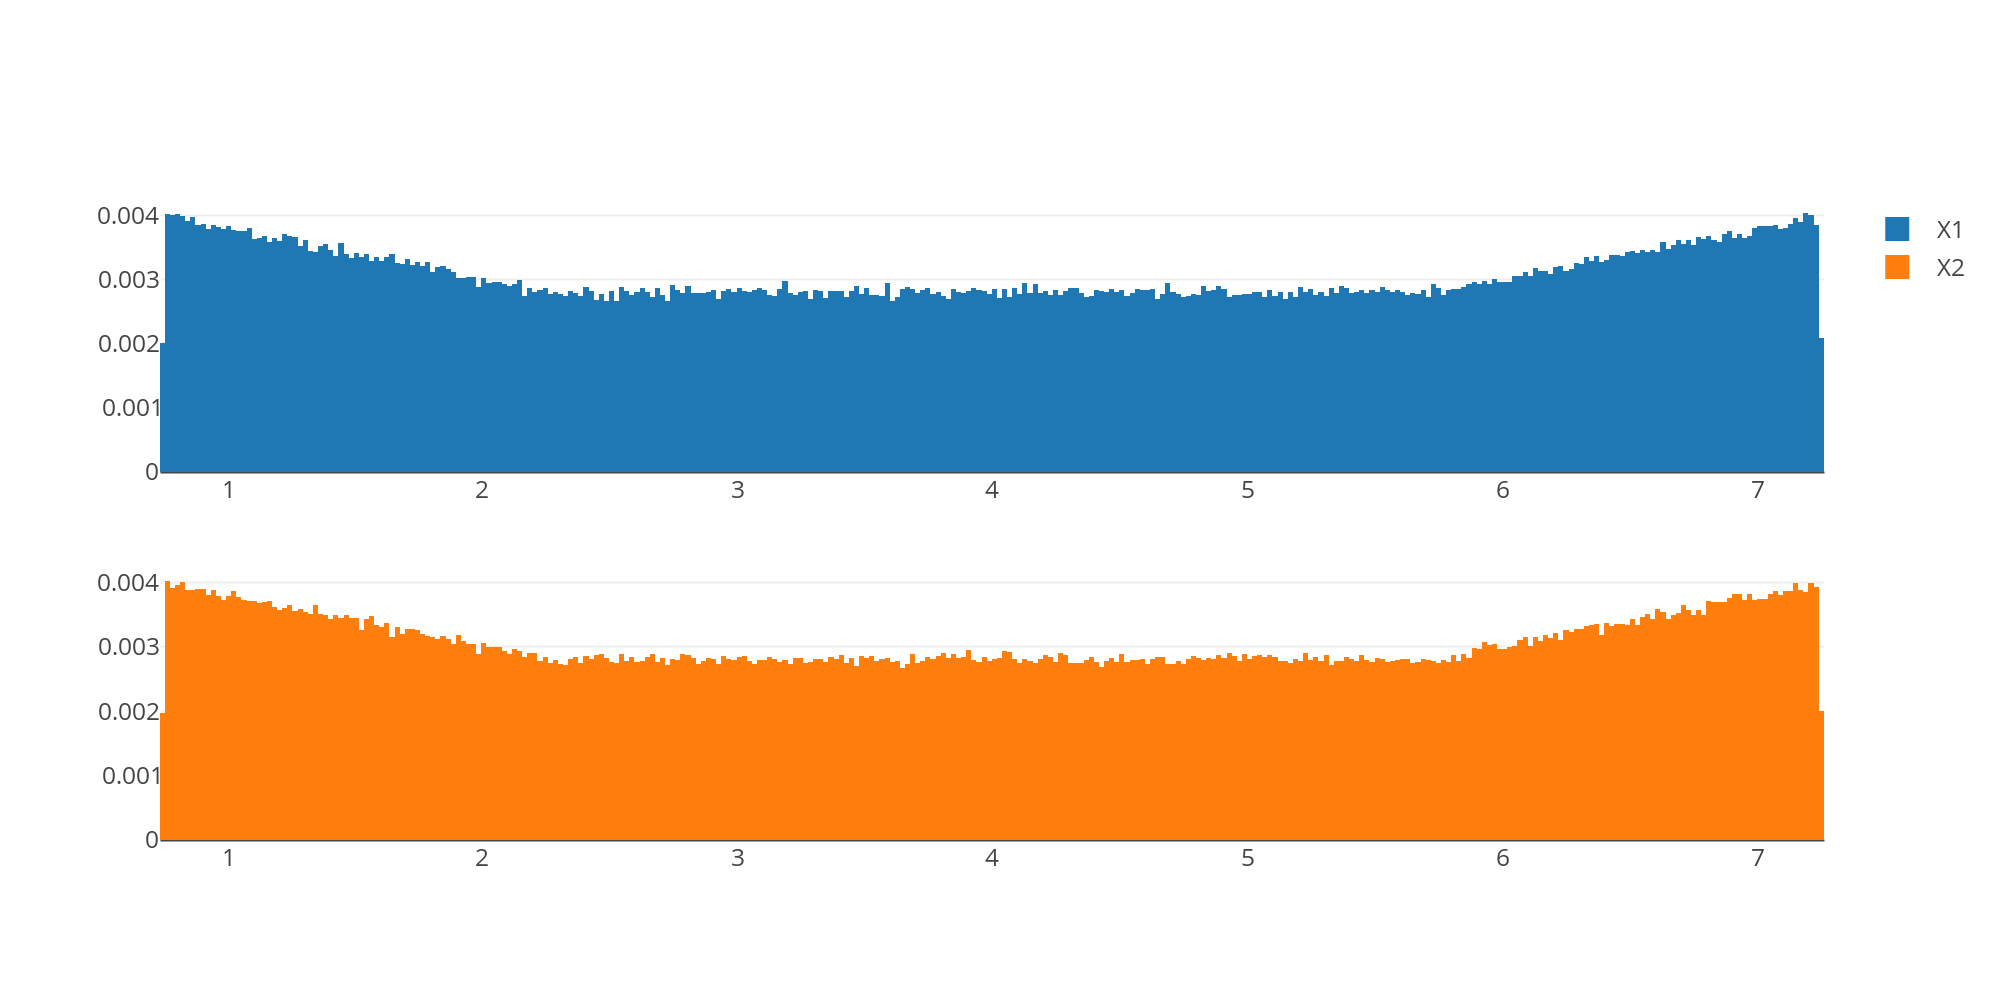

In [6]:
# Set up our sampler for configurations of 2 spheres.
sampler = DirectSampler(num_spheres=NUM_SPHERES, length=LENGTH, sigma=SIGMA)

s = sampler.sample(10**6)
x1, x2 = s.swapaxes(0, 1)

# Plot the distribution of x1 and x2
fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(Histogram(x=x1, name="X1", histnorm="probability"), 1, 1)
fig.append_trace(Histogram(x=x2, name="X2", histnorm="probability"), 2, 1)
pyimage.ishow(fig, width=1000, scale=2)

### Wrong sampling

Now we try with the wrong algorithm. We sample the configurations rejecting only second sphere in the case of an overlap.
We see that the configuration space of the first particle is not sampled correctly, being a trivial uniform distribution in $[\sigma, L-\sigma]$.

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



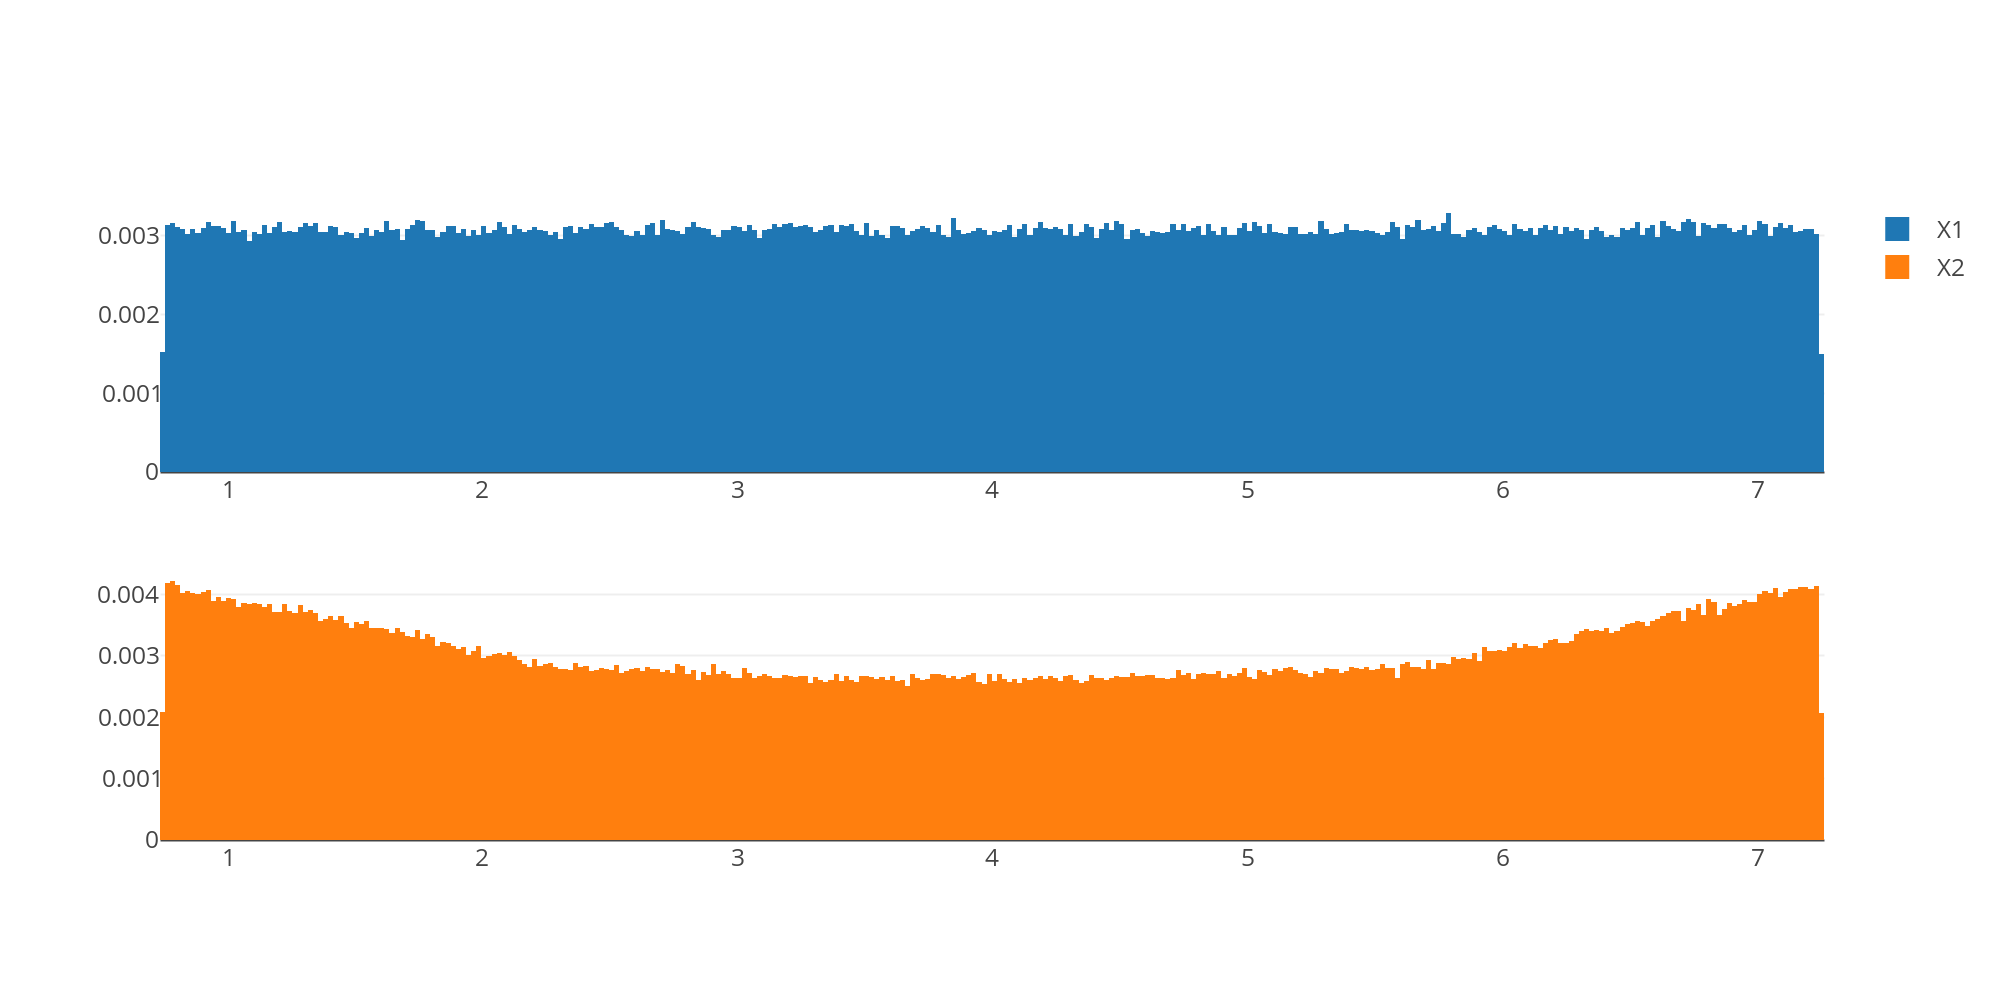

In [48]:
wrong_sampler = WrongSampler(num_spheres=2, length=LENGTH, sigma=SIGMA)

s = wrong_sampler.sample(10**6)
wrong_x1, wrong_x2 = s.swapaxes(0, 1)

# Plot the distribution of x1 and x2
fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(Histogram(x=wrong_x1, name="X1", histnorm="probability"), 1, 1)
fig.append_trace(Histogram(x=wrong_x2, name="X2", histnorm="probability"), 2, 1)
pyimage.ishow(fig, width=1000, scale=2)

A more intuitive way to compare the two algorithms—and highlight the problems with the wrong one—is to plot a heatmap of the configuration probability on the (x1, x2) plane.

What we want to get is a uniform sampling of all possible configurations. In the case of the direct sampling we find in fact a uniform distribution on the allowed configuration-space (i.e. excluding a diagonal strip of width $2\sigma$ representing the overlapping configurations). The allowed configurations are equiprobable. Notice the plot is symmetric with respect to the bisector, since (x1, x2) is as probable as (x2, x1).

For the wrong sampling algorithm the error here becomes evident: configurations where the first sphere is close to the boundaries are penalised.

In [76]:
lyt = Layout(xaxis=dict(range=(0, LENGTH), title="X1"), yaxis=dict(range=(0, LENGTH), title="X2"))
z, x, y = np.histogram2d(x=x1, y=x2, bins=80, normed=True)

data = [Heatmap(x=x, y=y, z=z.T)]
lyt.title = "Direct sampling"
py.iplot(Figure(data=data, layout=lyt))


wz, wx, wy = np.histogram2d(x=wrong_x1, y=wrong_x2, bins=80, normed=True)

wdata = [Heatmap(x=wx, y=wy, z=wz.T)]
lyt.title = "Wrong sampling"
py.iplot(Figure(data=wdata, layout=lyt))

## Performance of direct sampling

The direct sampler we implemented provides the right distributions, but saldy has very poor performance as we increase the number of spheres. The time required to generate a valid configuration will grow exponentially.

We can try to make a rough analytical estimate of the time required. The number of steps $T$ required to get a valid configuration (i.e. without overlaps) is geometrically distributed:

$$
\mathbb{E}[T] = \frac{1}{P_{acc}}
$$


where $P_{acc}$ is the probability of generating a single valid configuration. We must then calculate the probability of having no overlap when extracting the k-th sphere, but this is not completely trivial since it depends on the position of the previously extracted spheres. Since we are interested in asymptotic behaviour, we can just deal with an upper bound. If we consider $N$ spheres labeled by $k = 0, 1, \dots, N - 1$, the probability $p_k$ of accepting the k-th sphere is

$$
p_k \leq 1 - \frac{2\sigma}{L - 2\sigma}k
$$

thus

$$
P_{acc} = \prod_{k = 0}^{N - 1}p_k \leq \prod_{k=0}^{N-1}\left( 1 - \frac{2\sigma}{L - 2\sigma}k \right)
$$

We define $\lambda = \frac{L - 2\sigma}{2\sigma}$ (note that $\lambda$ has a physical meaning: it’s the maximum number of spheres of radius $\sigma$ we can place on the line of length $L$ without counting the first one). After few simple manipulations we get:

$$
P_{acc} \leq \lambda^{-N} \frac{\Gamma(\lambda)}{\Gamma(\lambda - N)}
$$

Let’s assume that $\lambda \gg 1$ (i.e. the line is long with respect to the sphere radius) and that $\lambda \gg N$ (i.e. we optimistically consider sparse configurations with N small with respect to the maximum number of spheres we could fit on the line). Then we can use Stirling’s expansion to get:

$$
\lambda^{-N} \frac{\Gamma(\lambda)}{\Gamma(\lambda - N)} \simeq e^{-N} \left(1 + \frac{N}{\lambda - N}\right)
$$

taking the logarithm and expanding to first order in $\frac{1}{\lambda}$ we have

$$
\log(P_{acc}) \lesssim -\frac{N^2}{2(\lambda - N)} + \frac{N}{2(\lambda - N)}  
$$

Eventually leading to the result

$$
\mathbb{E}[T] \gtrsim \exp\left(\frac{N^2}{2\lambda}\right)
$$

This is diverging very quickly! We can check this by doing a simple benchmark.
Fitting the data with a function $a\exp(b n^2)$ we obtain a coefficient $b \sim \frac{1}{2\lambda}$.

In [74]:
Ns = np.arange(1, 21)
times_direct = np.zeros_like(Ns, dtype=np.float_)
for i, n in enumerate(Ns):
    sampler_direct = DirectSampler(n, 10, 0.1)
    
    times_direct[i] = timeit.timeit(sampler_direct.sample, number=3)


# Try the fit (we fit the log or we would get overflows).
f = lambda x, a, b: a + (b * x**2)
a, b = curve_fit(f, Ns, np.log(times_direct))[0]

print("Fit: {:f}*exp({:f}*n^2)".format(np.exp(a), b))

data = [
    Scatter(x=Ns, y=times_direct, name="Data"),
    Scatter(x=Ns, y=np.exp(f(Ns, a, b)), name="exp(N^2) fit")
]
lyt = Layout(title="Execution time (log plot)", yaxis=dict(type="log"))
py.iplot(Figure(data=data, layout=lyt))

Fit: 0.000340*exp(0.025345*n^2)


We then implement a better algorithm named inflate/deflate to sample efficiently configurations in 1d. We can compare the benchmark with the direct sampler.

In [65]:
class InflateDeflateSampler(PinSampler):
    """Samples spheres using the inflate/deflate algorithm."""
    def _sample(self):
        # Deflated sample
        deflated = sorted(np.random.uniform(
            0,
            self.length - 2*self.num_spheres*self.sigma,
            size=self.num_spheres
        ))

        # Inflate
        sample = np.empty(self.num_spheres)
        for i, x in enumerate(deflated):
            sample[i] = x + (2*i + 1)*self.sigma
        
        return sample

In [73]:
times_infdef = np.zeros_like(Ns, dtype=np.float_)
for i, n in enumerate(Ns):
    sampler_infdef = InflateDeflateSampler(n, 10, 0.1)
    times_infdef[i] = timeit.timeit(sampler_infdef.sample, number=3)

py.iplot(Figure(
    data=[Scatter(x=Ns, y=times_direct, name="Direct"), Scatter(x=Ns, y=times_infdef, name="Inflate/deflate")],
    layout=Layout(title="Comparison between direct and inflate/deflate execution time")
))

Also, we can compare the inflate/deflate implementation with previous results to check whether it provides the correct distribution.

In [75]:
id_sampler = InflateDeflateSampler(num_spheres=2, length=LENGTH, sigma=SIGMA)

s = id_sampler.sample(10**6)

# Inflate/deflate returns ordered configurations, so we shuffle
# them to have a nicer comparison with the previous algorithms.
for c in s:
    np.random.shuffle(c)

id_x1, id_x2 = s.swapaxes(0, 1)

# Plot the distribution of x1 and x2
lyt = Layout(xaxis=dict(range=(0, LENGTH), title="X1"), yaxis=dict(range=(0, LENGTH), title="X2"))
z, x, y = np.histogram2d(x=id_x1, y=id_x2, bins=80, normed=True)

data = [Heatmap(x=x, y=y, z=z.T)]
lyt.title = "Inflate/deflate sampling"
py.iplot(Figure(data=data, layout=lyt))

## Probability distribution

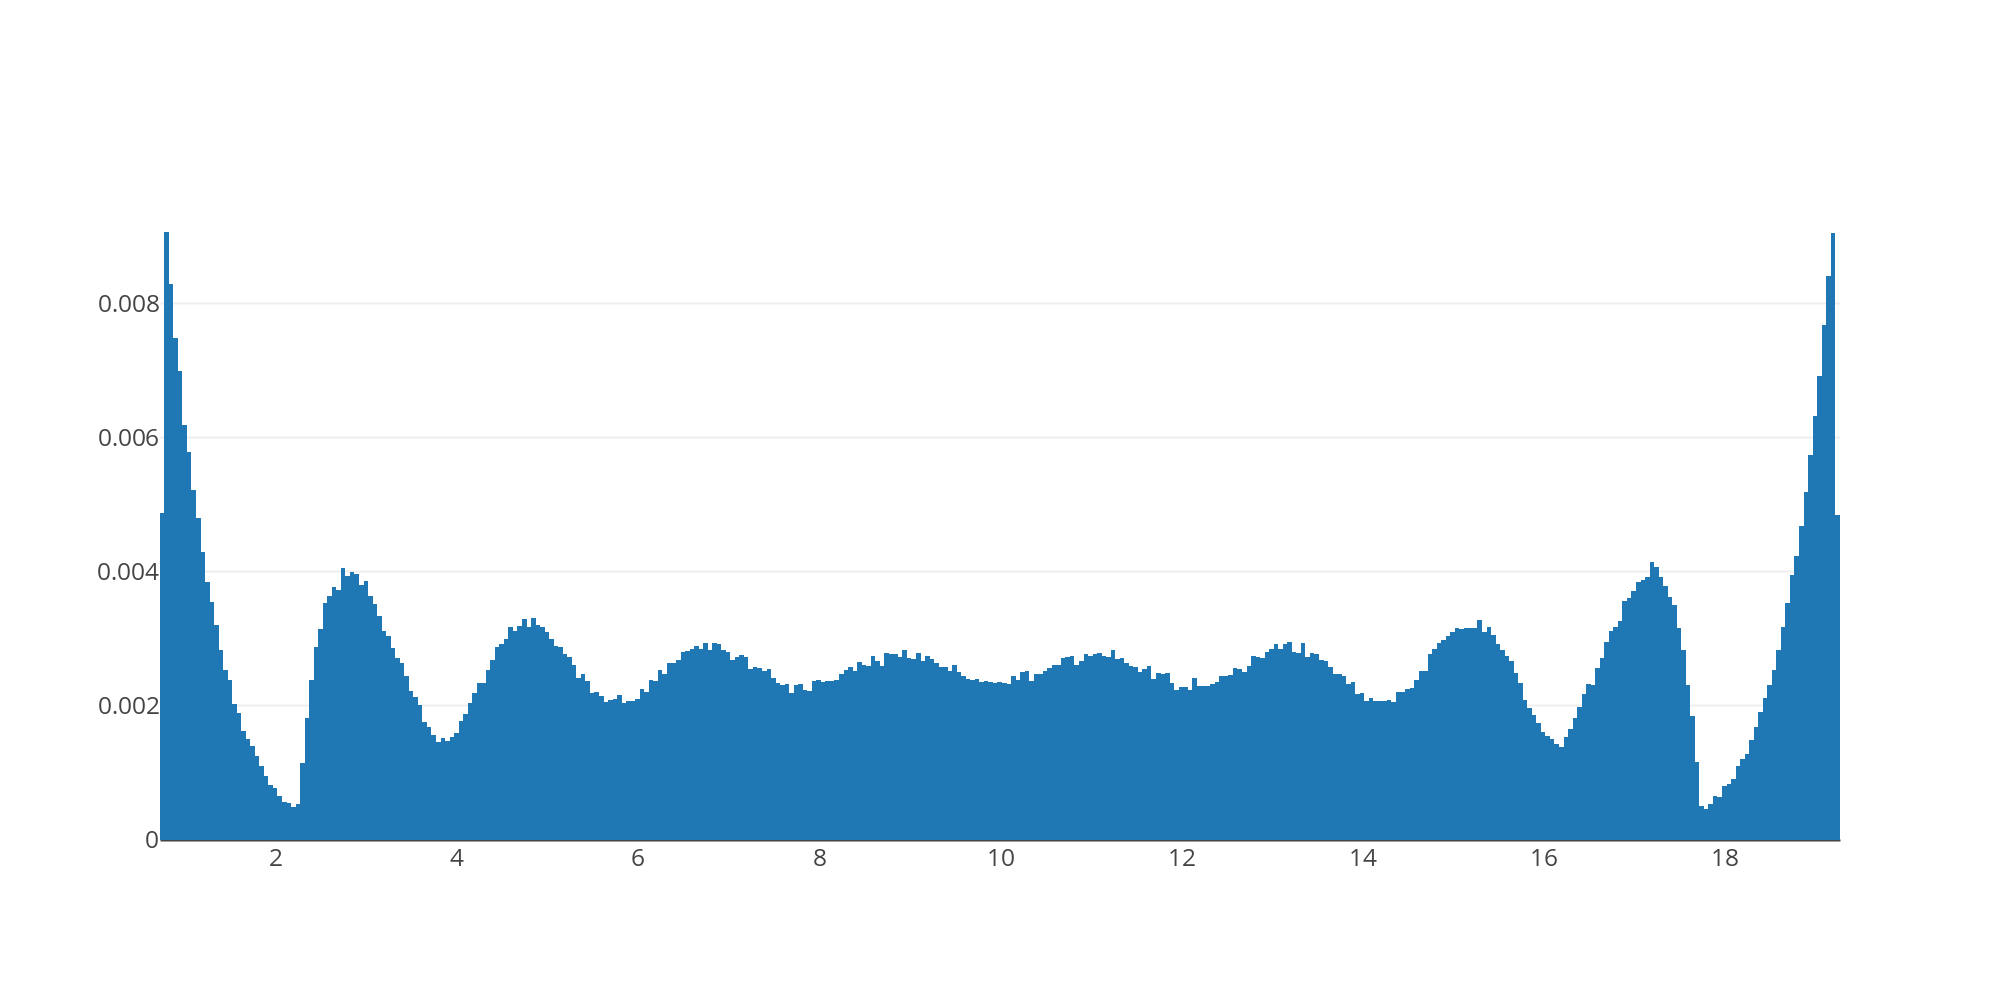

In [77]:
sampler = InflateDeflateSampler(num_spheres=10, length=20, sigma=0.75)
s = sampler.sample(10**5)
fig = Figure(data=[Histogram(x=s.flatten(), histnorm="probability")])
pyimage.ishow(fig, width=1000, scale=2)

### Partition sum
We can calculate the partition sum using traditional statitical physics methods. The energy of a configuration is infinite in case if there is an overlap and zero otherwise, leading to Boltzmann weights of 0 and 1 respectively. Considering indistinguishable spheres and defining ordered configurations (such that $x_N > x_{N-1} > \dots > x_1$) we can write:

$$
Z_{ord} = \int_{\sigma + 2\sigma(N - 1)}^{L-\sigma}dx_N \int_{\sigma + 2\sigma(N - 2)}^{x_N-2\sigma}dx_{N-1} \cdots \int_{\sigma + 2\sigma(k - 1)}^{x_{k+1} - 2\sigma}dx_k \cdots \int_{\sigma}^{x_2-2\sigma}dx_1 \cdot 1
$$

changing variables $r_k = x_k - (k-1)2\sigma - \sigma$ we get

$$
Z_{ord} = \int_{0}^{L - N 2\sigma}dr_N \int_{0}^{r_N}dr_{N-1} \cdots \int_{0}^{r_{k+1}}dr_k \cdot \int_{0}^{r_2}dr_1 = N! \cdot \left(L - N 2\sigma\right)^N
$$

If we want to consider the more general case of distinguishable spheres, we can just multiply by $N!$ (for each ordered configuration we have $N!$ permutations)

$$
Z = \left( L - N 2 \sigma \right)^N
$$

In [226]:
def Z(num_spheres, length, sigma):
    if length < 2*sigma*num_spheres:
        return 0.
    
    return (length - 2*sigma*num_spheres)**num_spheres


def gamma(x, num_spheres, length, sigma):
    s = 0.
    for k in range(num_spheres):
        s += Z(k, x - sigma, sigma) * Z(num_spheres - k - 1, length - x - sigma, sigma)
        
    return s/Z(num_spheres, length, sigma)

def gammak(k, x, num_spheres, length, sigma):
    return Z(k, x - sigma, sigma) * Z(num_spheres - k - 1, length - x - sigma, sigma) / Z(num_spheres, length, sigma)

In [248]:
num_spheres = 10
length = 20
sigma = 0.75
xs = np.arange(0, length, step=0.1)
ys = np.zeros_like(xs)
for i, x in enumerate(xs):
    ys[i] = gamma(x, num_spheres, length, sigma)
    

In [250]:
py.iplot([Scatter(x=xs, y=ys)])  # There is something going on!

In [287]:
# There is something going on!
tot = np.zeros_like(xs)

for k in range(num_spheres):
    ys = np.zeros_like(xs)
    for i, x in enumerate(xs):
        ys[i] = gammak(k, x, num_spheres, length, sigma)
    
    tot += ys / np.mean(ys) / 200  # GO WILD! guess the normalization!

py.iplot([Scatter(x=xs, y=tot)])
    

In [288]:
hist, bins = np.histogram(s.flatten(), bins=250, normed=True) 

In [289]:
py.iplot([Scatter(x=bins, y=hist, name="Simulation"), Scatter(x=xs, y=tot, name="Guess")])